In [1]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [ ]:
# https://pypi.org/project/textstat/
import textstat

In [31]:
import json
with open('states.json') as f:
    states = json.load(f)
with open('countries.json') as f:
    countries = json.load(f)

In [29]:
# check whether string contains state or country
def expresses_locality(string):
    for state in states.values():
        if state.lower() in string.lower():
            return True
    for country in countries.values():
        if country.lower() in string.lower():
            return True
    for state_abbrev in states.keys():
        abbrevs = []
        abbrevs.append(", " + state_abbrev + " ")
        abbrevs.append("," + state_abbrev + " ")
        for abbrev in abbrevs:
            if abbrev in string:
                return True
    return False

In [42]:
data = pd.read_json("train.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data['number_of_words_in_title']=data.apply(lambda x: len(x['request_title']), axis=1).astype(int)
data['number_of_words_in_text']=data.apply(lambda x: len(x['request_text']), axis=1).astype(int)
data['post_was_edited'] = data.apply(lambda x: 1 if "edit" in x['request_text'] else 0, axis=1).astype(int)
data['locality_in_title']=data.apply(lambda x: 1 if expresses_locality(x['request_title']) else 0, axis=1).astype(int)
data['locality_in_text']=data.apply(lambda x: 1 if expresses_locality(x['request_text']) else 0, axis=1).astype(int)
data['flesch_reading_ease_text']=data.apply(lambda x: textstat.flesch_reading_ease(x['request_text']), axis=1).astype(float)
data['flesch_reading_ease_title']=data.apply(lambda x: textstat.flesch_reading_ease(x['request_title']), axis=1).astype(float)
data['smog_index_text']=data.apply(lambda x: textstat.smog_index(x['request_text']), axis=1).astype(float)
data['smog_index_title']=data.apply(lambda x: textstat.smog_index(x['request_title']), axis=1).astype(float)
data['flesch_kincaid_grade_text']=data.apply(lambda x: textstat.flesch_kincaid_grade(x['request_text']), axis=1).astype(float)
data['flesch_kincaid_grade_title']=data.apply(lambda x: textstat.flesch_kincaid_grade(x['request_title']), axis=1).astype(float)
data['coleman_liau_index_text']=data.apply(lambda x: textstat.coleman_liau_index(x['request_text']), axis=1).astype(float)
data['coleman_liau_index_title']=data.apply(lambda x: textstat.coleman_liau_index(x['request_title']), axis=1).astype(float)
data['automated_readability_index_text']=data.apply(lambda x: textstat.automated_readability_index(x['request_text']), axis=1).astype(float)
data['automated_readability_index_title']=data.apply(lambda x: textstat.automated_readability_index(x['request_title']), axis=1).astype(float)
data['dale_chall_readability_score_text']=data.apply(lambda x: textstat.dale_chall_readability_score(x['request_text']), axis=1).astype(float)
data['dale_chall_readability_score_title']=data.apply(lambda x: textstat.dale_chall_readability_score(x['request_title']), axis=1).astype(float)
data['difficult_words_text']=data.apply(lambda x: textstat.difficult_words(x['request_text']), axis=1).astype(int)
data['difficult_words_title']=data.apply(lambda x: textstat.difficult_words(x['request_title']), axis=1).astype(int)
data['linsear_write_formula_text']=data.apply(lambda x: textstat.linsear_write_formula(x['request_text']), axis=1).astype(float)
data['linsear_write_formula_title']=data.apply(lambda x: textstat.linsear_write_formula(x['request_title']), axis=1).astype(float)
data['gunning_fog_text']=data.apply(lambda x: textstat.gunning_fog(x['request_text']), axis=1).astype(float)
data['gunning_fog_title']=data.apply(lambda x: textstat.gunning_fog(x['request_title']), axis=1).astype(float)
data['text_standard_text']=data.apply(lambda x: textstat.text_standard(x['request_text'],float_output=True), axis=1).astype(float)
data['text_standard_title']=data.apply(lambda x: textstat.text_standard(x['request_title'],float_output=True), axs=1).astype(float)
data['sentence_count_text']=data.apply(lambda x: textstat.sentence_count(x['request_text']), axis=1).astype(int)
data['sentence_count_title']=data.apply(lambda x: textstat.sentence_count(x['request_title']), axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)
data=data.drop(['requester_user_flair'], axis=1)
#data['requester_user_flair'] = data['requester_user_flair'].replace([None],"none")
#data['requester_user_flair'] = data['requester_user_flair'].astype("category").cat.codes
data.head(3)

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_number_of_comments_at_retrieval,request_text,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,...,difficult_words_text,difficult_words_title,linsear_write_formula_text,linsear_write_formula_title,gunning_fog_text,gunning_fog_title,text_standard_text,text_standard_title,sentence_count_text,sentence_count_title
0,0,1,0,0,Hi I am in need of food for my 4 children we a...,0.0000,792.420405,0.0,792.420405,0,...,5,2,40.50,2.0,29.79,15.73,30.0,2.0,1,1
1,2,5,0,0,I spent the last money I had on gas today. Im ...,501.1111,1122.279838,0.0,621.127072,0,...,0,2,3.00,5.0,3.00,12.00,3.0,6.0,2,1
2,0,3,0,0,My girlfriend decided it would be a good idea ...,0.0000,771.616181,0.0,771.616181,0,...,4,4,15.25,4.0,14.51,20.00,11.0,0.0,2,1


In [43]:
from sklearn.cross_validation import train_test_split

train_data, dev_data = train_test_split(data, test_size=0.3)
train_labels = train_data["requester_received_pizza"]
dev_labels = dev_data["requester_received_pizza"]
train_data=train_data.drop(['requester_received_pizza'], axis=1)
dev_data=dev_data.drop(['requester_received_pizza'], axis=1)

train_data_text = train_data["request_text"]
train_data=train_data.drop(['request_text'], axis=1)
dev_data_text = dev_data["request_text"]
dev_data=dev_data.drop(['request_text'], axis=1)

print (train_data.shape)
print (train_data_text.shape)
print (dev_data.shape)
print (dev_data_text.shape)

(2828, 51)
(2828,)
(1212, 51)
(1212,)


# Correlations

In [44]:
# Add train_data and labels to new dataframe to determine correlation matrix
data_for_corr = train_data.copy()
data_for_corr['requester_received_pizza'] = train_labels

corr_matrix = data_for_corr.corr()
corr_matrix['requester_received_pizza'].sort_values(ascending=False)

requester_received_pizza                                1.000000
requester_number_of_posts_on_raop_at_retrieval          0.465226
request_number_of_comments_at_retrieval                 0.292030
requester_number_of_comments_in_raop_at_retrieval       0.272495
requester_number_of_posts_on_raop_at_request            0.141404
requester_days_since_first_post_on_raop_at_retrieval    0.135002
requester_account_age_in_days_at_retrieval              0.129831
requester_number_of_comments_in_raop_at_request         0.124493
number_of_words_in_text                                 0.118622
difficult_words_text                                    0.116494
requester_days_since_first_post_on_raop_at_request      0.107513
number_of_upvotes_of_request_at_retrieval               0.087313
smog_index_text                                         0.084933
requester_number_of_comments_at_retrieval               0.082467
sentence_count_text                                     0.077731
dale_chall_readability_sc

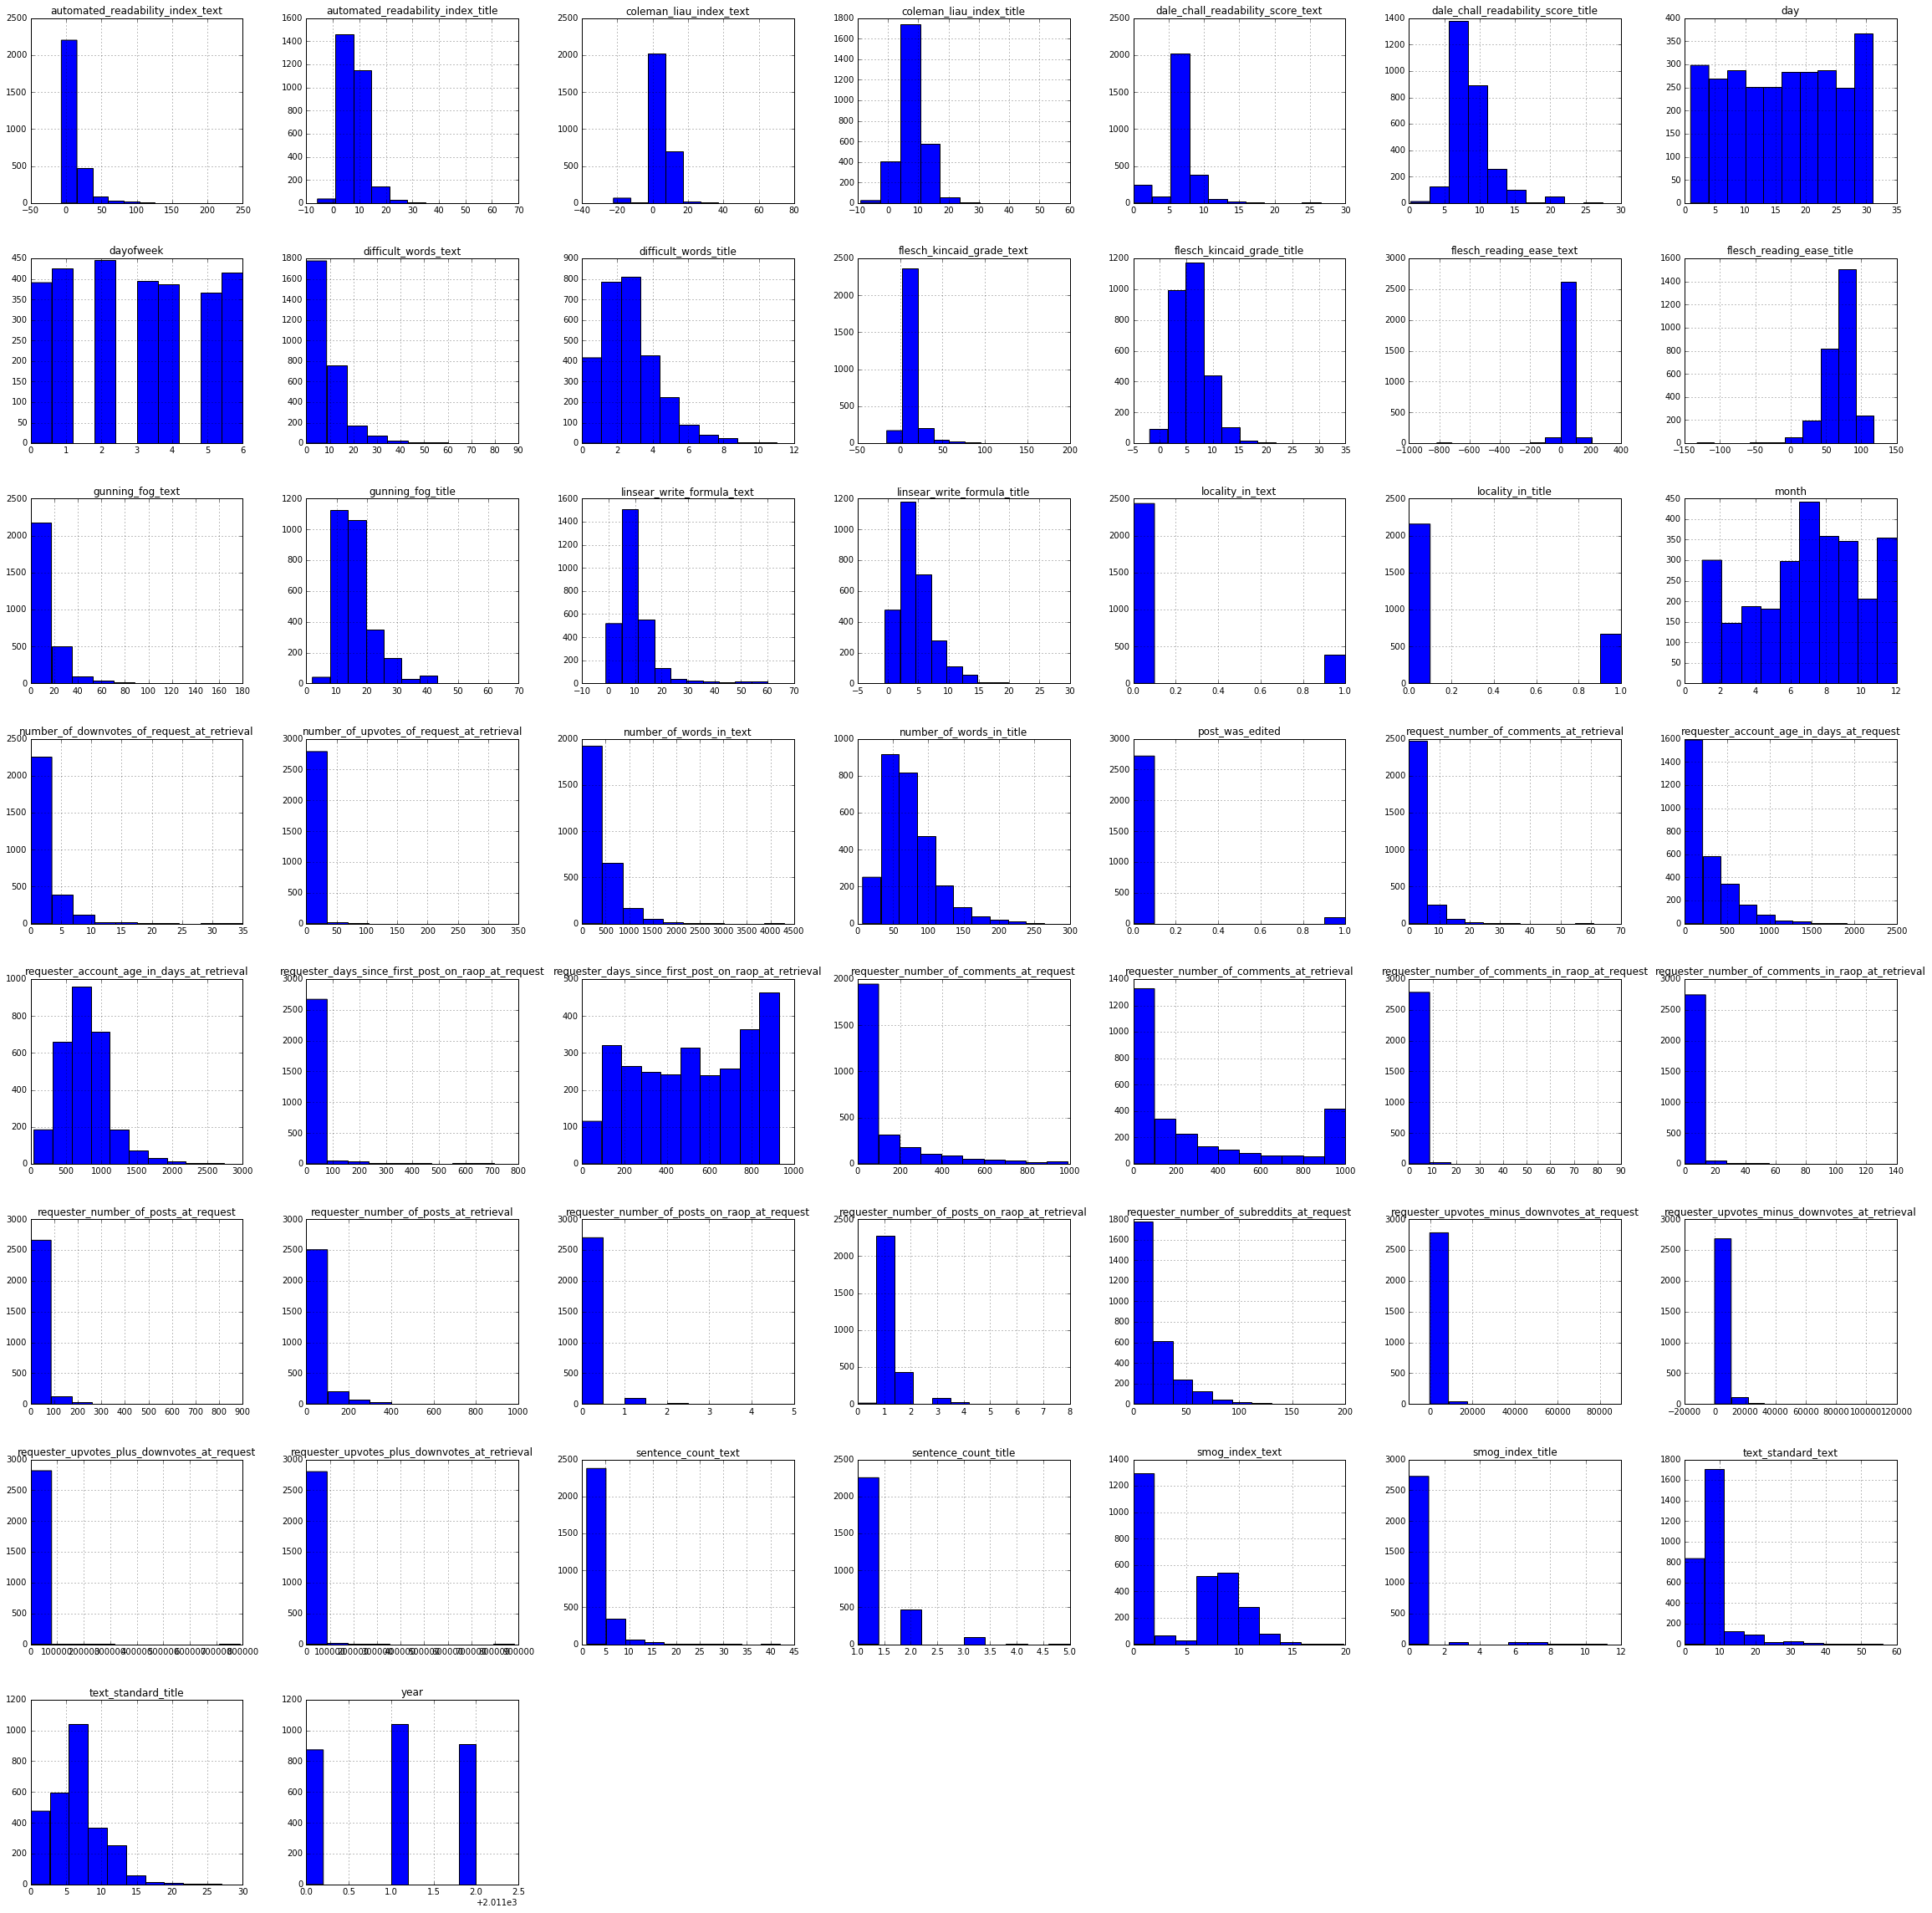

In [53]:
train_data.hist(figsize=(40,40))
plt.show()

In [52]:
lr = LogisticRegression().fit(train_data,train_labels)
y_pred = lr.predict(dev_data)
print "Accuracy = %1.3f" % lr.score(dev_data,dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.822
             precision    recall  f1-score   support

      False       0.83      0.96      0.89       912
       True       0.77      0.40      0.53       300

avg / total       0.81      0.82      0.80      1212



In [53]:
columns = ['requester_number_of_posts_on_raop_at_retrieval']

lr1 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr1.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr1.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.847
             precision    recall  f1-score   support

      False       0.87      0.94      0.90       912
       True       0.75      0.57      0.65       300

avg / total       0.84      0.85      0.84      1212



In [54]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval']

lr2 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr2.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr2.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.850
             precision    recall  f1-score   support

      False       0.85      0.96      0.91       912
       True       0.82      0.50      0.62       300

avg / total       0.85      0.85      0.84      1212



In [55]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval']

lr3 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr3.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr3.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.848
             precision    recall  f1-score   support

      False       0.86      0.96      0.90       912
       True       0.81      0.51      0.62       300

avg / total       0.84      0.85      0.84      1212



In [56]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval']

lr4 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr4.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr4.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.842
             precision    recall  f1-score   support

      False       0.85      0.96      0.90       912
       True       0.79      0.49      0.61       300

avg / total       0.84      0.84      0.83      1212



In [57]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request']

lr5 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr5.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr5.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.841
             precision    recall  f1-score   support

      False       0.85      0.96      0.90       912
       True       0.78      0.49      0.61       300

avg / total       0.83      0.84      0.83      1212



In [58]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval']

lr6 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr6.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr6.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.838
             precision    recall  f1-score   support

      False       0.85      0.95      0.90       912
       True       0.78      0.49      0.60       300

avg / total       0.83      0.84      0.82      1212



In [47]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval',
            'number_of_words_in_text']

lr7 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr7.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr7.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.823
             precision    recall  f1-score   support

      False       0.84      0.94      0.89       917
       True       0.72      0.45      0.55       295

avg / total       0.81      0.82      0.81      1212



In [48]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval',
            'number_of_words_in_text',
            'requester_account_age_in_days_at_retrieval']

lr8 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr8.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr8.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.822
             precision    recall  f1-score   support

      False       0.84      0.94      0.89       917
       True       0.72      0.44      0.55       295

avg / total       0.81      0.82      0.81      1212

